<div id="toc-static"></div>

This tutorial explains the use of the automated graph analysis method of the **pyphs** module that translates a **netlist** into a set of governing **differential-algebraic equations**. <!-- TEASER_END -->
The method exactly implements **algorithm 1** of the academic reference [[1]](http://www.mdpi.com/2076-3417/6/10/273/pdf), to which the reader is referred for technical details. For an introduction to **pyphs**, see the [Getting started tutorial](/tutos/tuto0).

The basics steps are

1 **Instanciate a `pyphs.PortHamiltonianObject`** with *e.g.*

Notice the `path='label'` option will create the folder for all data outputs in the current working directory, with name from the `label` option (here, `'mylabel'`). This path is accessible with `phs.path`.

2 **Create a *netlist file*:** The inputs of the graph analysis method are *netlists*, which are `*.net` text files (*e.g.* `mysystem.net`) where each line describes an element of the system, with 
* identification label, 
* list of connection nodes, 
* type of element, and 
* list of parameters.

3 **Associate `mysystem.net` to the `pyphs.PortHamiltonianObject`** with, for a `*.net` text file located at `netlist_path/mysystem.net`:
```python
phs.build_from_netlist('netlist_path/mysystem.net')
```
That's all!

The netlist creation step is detailed and illustrated on the simple resistor-coil-capacitor (RLC) circuit in the following subsections.

# Netlist's lines formating
The `netlist files` are simple `text` files with the `.net` extension. Each line corresponds to a component taken from the `pyphs.dictionary` module. The formating of a netlist line is as follows:
```
dico.comp label (node1, ..., nodeN): par1=(lab1, val1) par2=lab2 par3=val3
```
where
* component `comp` is a submodule from module `pyphs.dictionary.dico`,
* `label` is the component label (avoid creativity in chosen characters),
* the `node`'s are the labels associated with the N component's nodes (can be strings or numbers),
* the `par`'s are parameters identifiers defined in the component,
* the `lab`'s are new string labels for the parameters,
* the `val`'s are numerical values for the parameters.

The syntax for the parameters declaration is as follows:
* If both a string label and a numerical value is provided (as in `par1=(lab1, val1)`), a new symbol `phs.symbols(lab1)` will be created and associated with a key of the substitutions dictionary `phs.symbs.subs`, with associated value given by `val1`.
* If no numerical value is provided (as in `par2=lab2`), the parameter will be defined as a free-parameter in `phs.symbs.p` that must be specified for the simulations. 
* Else if no label is provided for the new component (as in `par3=val3`), the new label for the *i-th* parameter is defined as `label_pari` where `label` is the chosen component label.

# Datum node
The datum node is a special node considered as a reference for the system dynamics. To refer this node in the netlist and subsequent graph analysis, a special node label is associated. This datum label can be accessed from the `pyphs.graphs` module with

In [1]:
from pyphs.graphs import datum
datum

'#'

# Example: the RLC circuit
The components of the graph associated with the RLC circuit from the [Getting started tutorial](/tutos/tuto0) are
* A voltage source from **datum node** to node **A**,
* A $1$k$\Omega$ resistor from node **A** to node **B**,
* A $50$mH inductor from node **B** to **C**,
* A $2\mu$F capacitor from node **C** to **datum node**,

All these components are found in the `pyphs.dictionary.electronics` module. See the [dictionary index](/sphinx/pyphs.dictionary.html#module-pyphs.dictionary) for details.

We can see the call to the electronic source component `pyphs.dictionary.electronics.Source` is
```
electronics.source label ('node1', 'node2'): type='type'
```
where the source type declared by `type` is `voltage` or `current`. For the RLC circuit, we use the port label `OUT` so that the first line of the netlist is
```
electronics.source OUT ('ref' ,'A'): type='voltage';
```
Notice the semicolon terminaison.

Now, we have from the [dictionary index](/sphinx/pyphs.dictionary.html#module-pyphs.dictionary) that the call to the electronic resistor component `pyphs.dictionary.electronics.Resistor` is
```
electronics.resistor label ('node1', 'node2'): R=('Rlab', Rval)
```
where `label` is the resistor label, `'Rlab'` is the resistance parameter label  and `Rval` is the resistance parameter value (Ohms). For our RLC circuit, we use the resistor label `R1` and same for the resistance parameter label `'R1'` so that the second line of the netlist is
```
electronics.resistor R1 ('A', 'B'): R=('R1', 1000.0);
```
Accordingly, the third and fourth lines of the netlist are
```
electronics.inductor L1 ('B', 'C'): L=('L1', 0.05);
electronics.capacitor C1 ('C', 'ref'): C=('C1', 2e-06);
```
Finaly, we create a netlist file `RLC.net` in the folder containing this notebook with the following content:
```
electronics.source OUT ('ref', 'A'): type='voltage';
electronics.resistor R1 ('A', 'B'): R=('R1', 1000.0);
electronics.inductor L1 ('B', 'C'): L=('L1', 0.05);
electronics.capacitor C1 ('C', 'ref'): C=('C1', 2e-06);
```

# Automated netlist generation
There is two reasons you want to automatize the generation of the netlist:
1. It allows for easy management of sequential experiments (*e.g.* for which a single parameter take several values).
2. It is more robust with respect to possible changes of the netlist formating in the future of `pyphs`. 

This is done by defining each component as a line of the netlist in the `pyphs.Netlist`. This structure is defined by the `pyphs.graphs.Netlist` class, and is accessible with

In [2]:
from pyphs import Netlist
net = Netlist('rlc.net', clear = True)

Read netlist rlc.net
from folder 


Each line is defined with the `phs.graph.netlist.add_line` command, which takes python dicitonary with the following structure as arguments:
```python
netlist_line = {'dictionary': 'dico',
                'component': 'comp',
                'label': 'label',
                'nodes': ('node1', ..., 'nodeN'),
                'arguments': {'par1': "('lab1', val1)",
                              'par2': "'lab2'",
                              'par3': "val3"
                              }
                }
```
As an example, the declaration of the RLC components to the above `phs` object is as follows. 

Firstly, we define a dictionary for the voltage source:

In [3]:
source = {'dictionary': 'electronics',
          'component': 'source',
          'label': 'out',
          'nodes': (datum, 'A'),
          'arguments': {'type': 'voltage'}}

Secondly, we include this line to the netlist of the object with:

In [4]:
net.add_line(source)
net.netlist()

"electronics.source out ('#', 'A'): type=voltage;"

Now, the netlist of the phs object includes a new line:

In [5]:
print(net.netlist())

electronics.source out ('#', 'A'): type=voltage;


We process the same for the resistor, inductor and capacitor components:

In [6]:
# resistor
resistance = {'dictionary': 'electronics',
              'component': 'resistor',
              'label': 'R1',
              'nodes': ('A', 'B'),
              'arguments': {'R': ('R1', 1e3)}}
net.add_line(resistance)

# inductor
inductor = {'dictionary': 'electronics',
            'component': 'inductor',
            'label': 'L1',
            'nodes': ('B', 'C'),
            'arguments': {'L': ('L1', 5e-2)}}
net.add_line(inductor)

# capacitor
capacitor = {'dictionary': 'electronics',
             'component': 'capacitor',
             'label': 'C1',
             'nodes': ('C', datum),
             'arguments': {'C': ('C1', 2e-6)}}
net.add_line(capacitor)

The netlist now includes four lines:

In [7]:
for line in net:
    print(line)

{'dictionary': 'electronics', 'component': 'source', 'label': 'out', 'nodes': ('#', 'A'), 'arguments': {'type': 'voltage'}}
{'dictionary': 'electronics', 'component': 'resistor', 'label': 'R1', 'nodes': ('A', 'B'), 'arguments': {'R': ('R1', 1000.0)}}
{'dictionary': 'electronics', 'component': 'inductor', 'label': 'L1', 'nodes': ('B', 'C'), 'arguments': {'L': ('L1', 0.05)}}
{'dictionary': 'electronics', 'component': 'capacitor', 'label': 'C1', 'nodes': ('C', '#'), 'arguments': {'C': ('C1', 2e-06)}}


or equivalently with

In [8]:
print(net.netlist())

electronics.source out ('#', 'A'): type=voltage;
electronics.resistor R1 ('A', 'B'): R=('R1', 1000.0);
electronics.inductor L1 ('B', 'C'): L=('L1', 0.05);
electronics.capacitor C1 ('C', '#'): C=('C1', 2e-06);


The netlist is written in the current working directory with:

In [9]:
net.write()

This generates the following [RLC.net](/pyphs_outputs/RLC_auto/RLC.net) file. 
# Graph analysis
The differential-algebraic equations that govern the system are obtained with the `phs.build_from_netlist` method as follows:

In [10]:
core = net.to_core()

Build graph out...
Build graph R1...
Build graph L1...
Build graph C1...
Build graph rlc...
Build core rlc...


Voila. 

Now, we can *e.g.* generate a latex description of the system with:

In [11]:
core.texwrite()

Build graph out...
Build graph R1...
Build graph L1...
Build graph C1...
Build graph rlc...


which generates that [RLC.tex](/pyphs_outputs/rlc.tex) in the folder pointed by `phs.paths['tex']`. Compiling this file yields the following [RLC.pdf](/pyphs_outputs/rlc.pdf).

The elements of the system structure are accessed as follows. First, we activate nice representations of symbolic relations with `mathjax` from `sympy.init_printing`:

In [12]:
from sympy import init_printing
init_printing(use_latex='mathjax')

The relevant system arguments are listed below:

In [13]:
print('x=')
core.x

x=


[xL₁, xC₁]

In [14]:
print('w=')
core.w

w=


[wR₁]

In [15]:
print('u=')
core.u

u=


[uout]

In [16]:
print('y=')
core.y

y=


[yout]

In [17]:
print('p=')
core.p

p=


[]

In [18]:
print('H=')
core.H

H=


       2          2
0.5⋅xL₁    0.5⋅xC₁ 
──────── + ────────
   L₁         C₁   

In [19]:
print('z=')
core.z

z=


[R₁⋅wR₁]

In [20]:
print('M=')
core.M

M=


⎡ 0   -1.0  -1.0  -1.0⎤
⎢                     ⎥
⎢1.0   0     0     0  ⎥
⎢                     ⎥
⎢1.0   0     0     0  ⎥
⎢                     ⎥
⎣1.0   0     0     0  ⎦

In [21]:
print('J=')
core.J()

J=


⎡ 0   -1.0  -1.0  -1.0⎤
⎢                     ⎥
⎢1.0   0     0     0  ⎥
⎢                     ⎥
⎢1.0   0     0     0  ⎥
⎢                     ⎥
⎣1.0   0     0     0  ⎦

In [22]:
print('R=')
core.R()

R=


⎡0  0  0  0⎤
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎣0  0  0  0⎦

In [23]:
print('parameters :')
core.subs

parameters :


{C₁: 2e-06, L₁: 0.05, R₁: 1000.0}

# Simulation
The same simulation as in the [Getting started tutorial](/tutos/tuto0) is performed as follows:

In [24]:
from pyphs import signalgenerator
from pyphs import Simulation
import warnings; 
warnings.simplefilter('ignore')


# Simulation options
config = {'fs': 48e3,  # Samplerate (Hz)
          'split': True,
          'grad': 'theta',
          'theta': 0.5,
       }

simu = core.to_simulation(config=config)

# Signal parameters
A = 100.                           # Signal amplitude (V)
f0 = 100.                          # Signal frequency (Hz)
tsig = 5/f0                        # Signal duration (s)


# signal generator
vout = signalgenerator(which="sin",      # Sinusoidal signal
                       A=A,              # Amplitude
                       f0=f0,            # Frequency
                       tsig=tsig,           # Number of time-steps
                       fs=config['fs'],  # Samplerate
                       ramp_on=True,     # Linear increase
                      )

u = list(([el, ] for el in vout()))

# Init simulation
simu.init(u=u)

# Process simulation
simu.process()

Build method rlc...
    Init Method...
    Split Linear/Nonlinear...
    Build numerical structure...
    Split Implicit/Resolved...
    Re-Build numerical structure...
    Init update actions...
    Init arguments...
        Build x
        Build dx
        Build w
        Build u
        Build p
        Build vl
        Build o
    Init functions...
        Build jactempFll
        Build z
        Build ud_o
        Build dxH
        Build Gl
        Build y
Build numeric rlc...
    Build numerical evaluation of x
    Build numerical evaluation of ud_x
    Build numerical evaluation of o
    Build numerical evaluation of ud_o
    Build numerical evaluation of jactempFll
    Build numerical evaluation of ijactempFll
    Build numerical evaluation of Gl
    Build numerical evaluation of vl
    Build numerical evaluation of ud_vl
    Build numerical evaluation of dxH
    Build numerical evaluation of z
    Build numerical evaluation of y
    Build numerical evaluation of dx
    Build nu

Build numerical evaluations...
Build numerical evaluations...
Build numerical evaluations...
Build numerical evaluations...


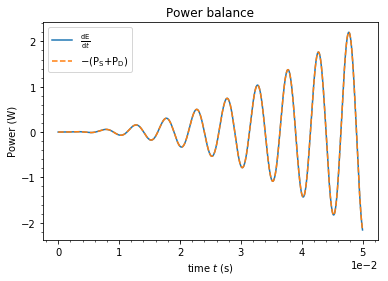

In [25]:
import matplotlib.pyplot as plt
# Shows the plots in the notebook
%matplotlib inline

# plot power balance
fig, ax = simu.data.plot_powerbal()

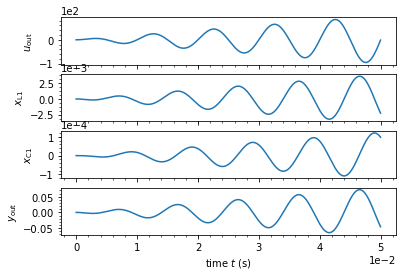

In [26]:
fig, axes = simu.data.plot(['u', 'x', 'y'])